# Directory change

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Parkisons_detection"
# /content/drive/MyDrive/Colab Notebooks/Parkisons_detection

/content/drive/MyDrive/Colab Notebooks/Parkisons_detection


# Data Loading

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.mixed_precision import set_global_policy
import time

In [ ]:
# Enable mixed precision for faster training
set_global_policy('mixed_float16')

In [ ]:
import numpy as np
import tensorflow as tf
import os

# Set paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/Parkisons_detection'
preprocessed_dir = os.path.join(base_dir, 'Preprocessed')

# Load data
train_paths = np.load(os.path.join(preprocessed_dir, 'train_paths.npy'))
val_paths = np.load(os.path.join(preprocessed_dir, 'val_paths.npy'))
train_labels = np.load(os.path.join(preprocessed_dir, 'train_labels.npy'))
val_labels = np.load(os.path.join(preprocessed_dir, 'val_labels.npy'))

print(f"✅ Loaded {len(train_paths)} training and {len(val_paths)} validation samples.")

✅ Loaded 2611 training and 653 validation samples.


In [ ]:
# Image size & batch
img_size = (224, 224)
batch_size = 64

In [ ]:
# ⬛ 2. Optimized Preprocessing
def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  # faster decode
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def create_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets
train_ds = create_dataset(train_paths, train_labels, training=True)
val_ds = create_dataset(val_paths, val_labels, training=False)

# InceptionV3 + Attention model

## InceptionV3 + Attention model building

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# input_layer = Input(shape=(299, 299, 3))

# # Base model
# base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_layer)
# base_model.trainable = False

# x = base_model.output

# # Apply the attention block
# x = SpatialAttention()(x)

# # Classification head
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.3)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)
# output_layer = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=input_layer, outputs=output_layer)
# model.summary()

# Build model
def build_model(input_shape=(224, 224, 3)):
    input_layer = Input(shape=input_shape)

    base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_layer)
    base_model.trainable = False  # Freeze base layers

    x = base_model.output
    x = SpatialAttention()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.summary()
    return model

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers

class SpatialAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = None  # Will initialize in build()

    def build(self, input_shape):
        # Pooling outputs 2 channels (avg and max), so conv expects 2 channels
        channel_dim = 2  # always (avg_pool, max_pool)
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        super().build(input_shape)

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)  # (None, H, W, 1)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)   # (None, H, W, 1)
        concat = tf.concat([avg_pool, max_pool], axis=-1)          # (None, H, W, 2)
        attention = self.conv(concat)                              # Conv2D on 2 channels
        return inputs * attention

    def get_config(self):
        return super().get_config()

# class SpatialAttention(tf.keras.layers.Layer):
#     def __init__(self, return_attention=False, **kwargs):
#         super(SpatialAttention, self).__init__(**kwargs)
#         self.conv = None
#         self.return_attention = return_attention

#     def build(self, input_shape):
#         self.conv = tf.keras.layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
#         super().build(input_shape)

#     def call(self, inputs):
#         # Keep dtype consistent
#         inputs = tf.cast(inputs, self.compute_dtype)

#         avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
#         max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
#         concat = tf.concat([avg_pool, max_pool], axis=-1)
#         attention = self.conv(concat)

#         if self.return_attention:
#             return attention

#         # Ensure attention is cast to same dtype before multiplying
#         attention = tf.cast(attention, self.compute_dtype)
#         return inputs * attention

#     def get_config(self):
#         config = super().get_config()
#         config.update({'return_attention': self.return_attention})
#         return config


In [ ]:
# Instantiate the model
model = build_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 111, 111,  │        864 │ cast_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_99[0][0] 

 Total params: 22,065,284 (84.17 MB)

 Trainable params: 262,500 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

## Compile and Train the InceptionV3 + Attention model

In [ ]:
# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# # Optional: callbacks
# early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
# ⬛ 5. Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# ⬛ 6. Time Logger
class EpochTimeLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.epoch_times.append(elapsed)
        print(f"🕒 Epoch {epoch+1} time: {elapsed:.2f} sec")

time_logger = EpochTimeLogger()


In [ ]:
# ⬛ 7. Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop, time_logger],
    verbose=1
)


Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5894 - loss: 0.6887🕒 Epoch 1 time: 570.82 sec
41/41 ━━━━━━━━━━━━━━━━━━━━ 571s 14s/step - accuracy: 0.5905 - loss: 0.6876 - val_accuracy: 0.8224 - val_loss: 0.4692
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7397 - loss: 0.5304🕒 Epoch 2 time: 2.35 sec
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7398 - loss: 0.5302 - val_accuracy: 0.8331 - val_loss: 0.4112
Epoch 3/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7732 - loss: 0.4751🕒 Epoch 3 time: 2.24 sec
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7731 - loss: 0.4754 - val_accuracy: 0.8392 - val_loss: 0.3823
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7903 - loss: 0.4479🕒 Epoch 4 time: 2.23 sec
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7903 - loss: 0.4480 - val_accuracy: 0.8453 - val_loss: 0.3618
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7988 - loss: 0.4244🕒 Epoch 5 time: 2.38

## Training graphs

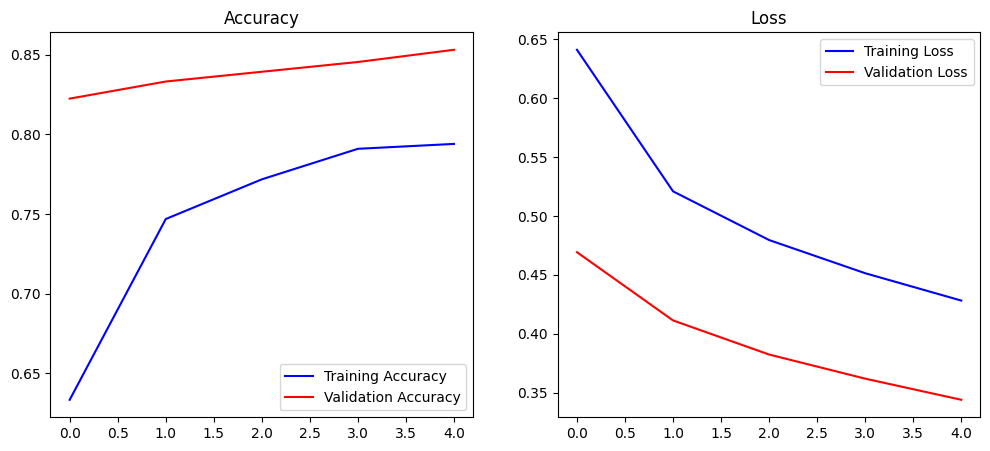

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_training(history)

In [ ]:
print("⏱️ Epoch durations (in sec):", time_logger.epoch_times)
print("🕑 Avg epoch time:", sum(time_logger.epoch_times) / len(time_logger.epoch_times), "sec")

⏱️ Epoch durations (in sec): [570.8175311088562, 2.3450677394866943, 2.2356181144714355, 2.2290921211242676, 2.3765110969543457]
🕑 Avg epoch time: 116.0007640361786 sec


## Saving the Model

In [ ]:
model_save_dir = '/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/models/'

Load without optimizer (recommended for inference / analysis)
When loading the model for evaluation or inference only, skip the optimizer state:

   
model = tf.keras.models.load_model(
    '/path/to/your_model.keras',
    custom_objects={'SpatialAttention': SpatialAttention},
    compile=False  # Don't load optimizer
)
Then recompile only if needed:

   
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# model_path = os.path.join(model_save_dir, 'inception_attention_final.h5')
model_path = os.path.join(model_save_dir, 'inception_attention_final.keras')
model.save(model_path)
print(f"💾 Model saved to: {model_path}")


💾 Model saved to: /content/drive/MyDrive/Colab Notebooks/Parkisons_detection/models/inception_attention_final.keras


## Loading the model

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Parkisons_detection


In [ ]:
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = "/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/models/inception_attention_final.keras"
# /content/drive/MyDrive/Colab Notebooks/Parkisons_detection/models/inception_attention_final.keras

# Load model
inception_w_attention_model = load_model(model_path, custom_objects={'SpatialAttention': SpatialAttention})

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 12 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Compile
inception_w_attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
loss, accuracy = inception_w_attention_model.evaluate(val_ds)
print(f"🧪 Validation Accuracy: {accuracy * 100:.2f}%")
print(f"📉 Validation Loss: {loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8595 - loss: 0.3565
🧪 Validation Accuracy: 85.30%
📉 Validation Loss: 0.3438


## Evaluation Metrics

In [ ]:
def predict_sample(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))  # match your model input
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, 0)  # add batch dimension

    prediction = inception_w_attention_model.predict(img)[0][0]
    label = "Parkinson" if prediction > 0.5 else "Healthy"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"Prediction: {prediction}")
    print(f"🧠 Prediction: {label} ({confidence * 100:.2f}%)")

# Example
# predict_sample(val_paths[150])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediction: 0.53466796875
🧠 Prediction: Parkinson (53.47%)


In [ ]:
# Example
predict_sample(val_paths[150])

In [ ]:
val_paths[0]

np.str_('/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/Dataset/Healthy/Healthy1563.png')

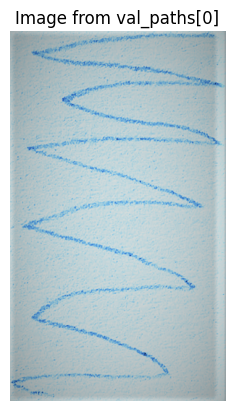

📄 Image path: /content/drive/MyDrive/Colab Notebooks/Parkisons_detection/Dataset/Parkinson/Parkinson1631.png


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Get image path
img_path = val_paths[150]

# Load and display
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)

plt.imshow(img.numpy().astype("uint8"))
plt.axis('off')
plt.title("Image from val_paths[0]")
plt.show()

# Optional: Print path
print(f"📄 Image path: {img_path}")

In [ ]:
import numpy as np

# Collect all true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = inception_w_attention_model.predict(images, verbose=0)
    y_pred.extend(preds.flatten())
    y_true.extend(labels.numpy())

# Convert predictions to binary (0 = Healthy, 1 = Parkinson)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_binary, target_names=["Healthy", "Parkinson"]))

              precision    recall  f1-score   support

     Healthy       0.80      0.94      0.86       327
   Parkinson       0.93      0.77      0.84       326

    accuracy                           0.85       653
   macro avg       0.86      0.85      0.85       653
weighted avg       0.86      0.85      0.85       653



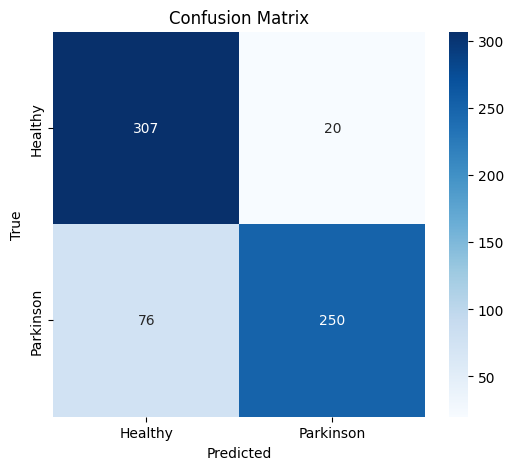

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Healthy", "Parkinson"], yticklabels=["Healthy", "Parkinson"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


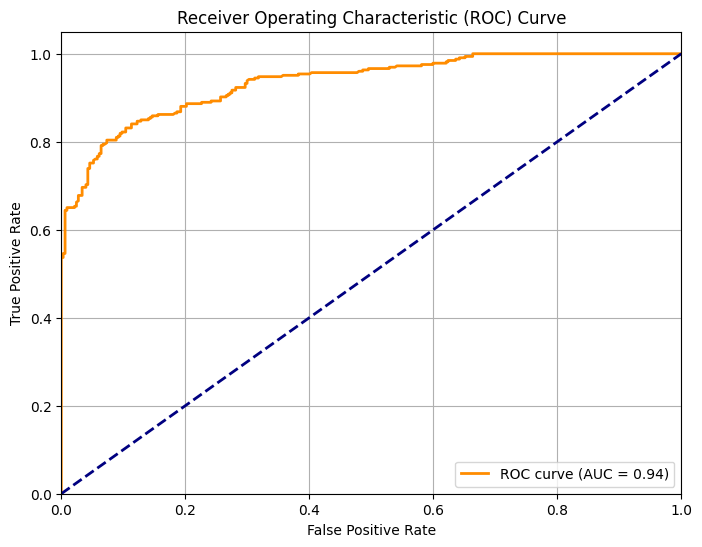

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_true already prepared
# y_pred = raw probabilities from model (NOT thresholded)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

AUC ≈ 1.0 → Perfect separation between Healthy and Parkinson’s

AUC ≈ 0.5 → No better than random guessing

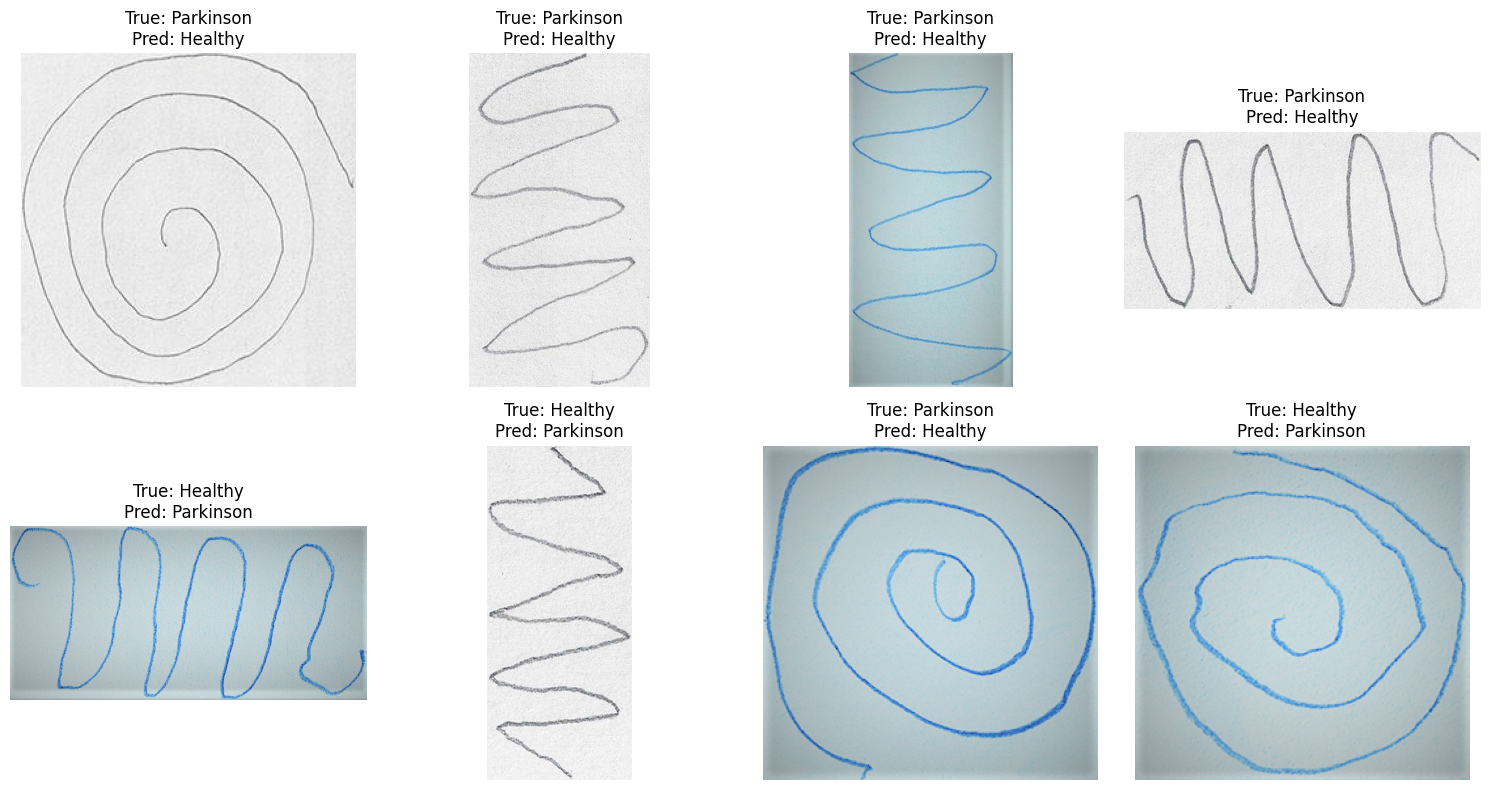

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure val_paths and val_labels are loaded
val_paths = np.load("/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/Preprocessed/val_paths.npy")
val_labels = np.load("/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/Preprocessed/val_labels.npy")

# Show first N misclassified
num_to_show = 8
count = 0

plt.figure(figsize=(15, 8))

for i in range(len(y_true)):
    if y_true[i] != y_pred_binary[i]:
        img = tf.io.read_file(val_paths[i])
        img = tf.image.decode_jpeg(img, channels=3)
        plt.subplot(2, 4, count + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"True: {'Parkinson' if y_true[i] else 'Healthy'}\nPred: {'Parkinson' if y_pred_binary[i] else 'Healthy'}")
        count += 1
        if count == num_to_show:
            break

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


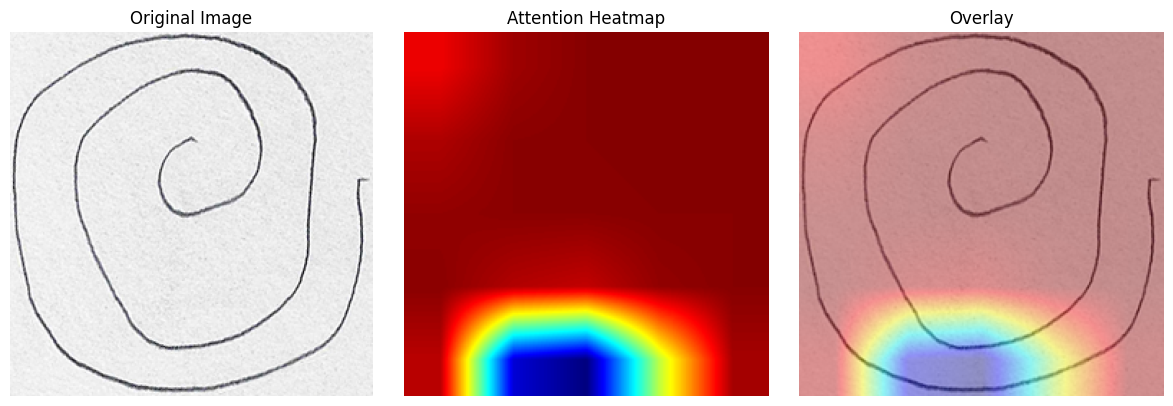

In [ ]:
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load paths
val_paths = np.load("/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/Preprocessed/val_paths.npy")

# Load and preprocess one sample
sample_path = val_paths[10]  # or any index
img_raw = tf.io.read_file(sample_path)
img = tf.image.decode_jpeg(img_raw, channels=3)
img_resized = tf.image.resize(img, [224, 224]) / 255.0
img_batch = tf.expand_dims(img_resized, axis=0)

# Create new attention-extracting model
for layer in inception_w_attention_model.layers:
    if isinstance(layer, SpatialAttention):
        attention_layer = layer
        break

# Set the attention layer to return attention
attention_layer.return_attention = True

# Create sub-model to get attention output
attention_model = Model(inputs=inception_w_attention_model.input, outputs=attention_layer.output)

# Predict attention map
attention_map = attention_model.predict(img_batch)[0, :, :, 0]  # shape (H, W)

# Normalize attention for display
attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))
attention_map = np.uint8(255 * attention_map)

# Resize attention to match image
attention_map_resized = tf.image.resize(tf.expand_dims(attention_map, -1), [224, 224])
attention_map_resized = tf.squeeze(attention_map_resized).numpy().astype("uint8")

# Apply colormap
import cv2
heatmap = cv2.applyColorMap(attention_map_resized, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Overlay heatmap on image
# overlay = cv2.addWeighted(img_resized.numpy(), 0.6, heatmap / 255.0, 0.4, 0)
# Overlay heatmap on image (with correct dtype handling)
overlay = cv2.addWeighted(
    img_resized.numpy().astype(np.float32),
    0.6,
    (heatmap / 255.0).astype(np.float32),
    0.4,
    0
)


# Show
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img.numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Attention Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy*100:.2f}% | Loss: {loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 502ms/step - accuracy: 0.8595 - loss: 0.3565
Validation Accuracy: 85.30% | Loss: 0.3438


In [ ]:
# Example
predict_sample(val_paths[150])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction: 0.53466796875
🧠 Prediction: Parkinson (53.47%)


# Xception + Attention model

Step 1: Import Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class SpatialAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = None  # Will initialize in build()

    def build(self, input_shape):
        # Pooling outputs 2 channels (avg and max), so conv expects 2 channels
        channel_dim = 2  # always (avg_pool, max_pool)
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        super().build(input_shape)

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)  # (None, H, W, 1)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)   # (None, H, W, 1)
        concat = tf.concat([avg_pool, max_pool], axis=-1)          # (None, H, W, 2)
        attention = self.conv(concat)                              # Conv2D on 2 channels
        return inputs * attention

    def get_config(self):
        return super().get_config()

# class SpatialAttention(tf.keras.layers.Layer):
#     def __init__(self, return_attention=False, **kwargs):
#         super(SpatialAttention, self).__init__(**kwargs)
#         self.conv = None
#         self.return_attention = return_attention

#     def build(self, input_shape):
#         self.conv = tf.keras.layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
#         super().build(input_shape)

#     def call(self, inputs):
#         # Keep dtype consistent
#         inputs = tf.cast(inputs, self.compute_dtype)

#         avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
#         max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
#         concat = tf.concat([avg_pool, max_pool], axis=-1)
#         attention = self.conv(concat)

#         if self.return_attention:
#             return attention

#         # Ensure attention is cast to same dtype before multiplying
#         attention = tf.cast(attention, self.compute_dtype)
#         return inputs * attention

#     def get_config(self):
#         config = super().get_config()
#         config.update({'return_attention': self.return_attention})
#         return config


Define the model

In [ ]:
def build_xception_attention_model(input_shape=(224, 224, 3)):
    input_layer = Input(shape=input_shape)

    # Load Xception base
    base_model = Xception(include_top=False, weights='imagenet', input_tensor=input_layer)
    base_model.trainable = False  # Freeze base model for now

    # Attention + Head
    x = base_model.output
    x = SpatialAttention()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.summary()
    return model

In [ ]:
# Build model
model = build_xception_attention_model()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_6 (Cast)       │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ cast_6[0][0]      │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0

 Total params: 21,123,980 (80.58 MB)

 Trainable params: 262,500 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:

# Callbacks (optional)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ⬛ 6. Time Logger
class EpochTimeLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.epoch_times.append(elapsed)
        print(f"🕒 Epoch {epoch+1} time: {elapsed:.2f} sec")

time_logger = EpochTimeLogger()


In [ ]:
# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop,time_logger],
    verbose=1
)

Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5457 - loss: 0.6818🕒 Epoch 1 time: 518.50 sec
41/41 ━━━━━━━━━━━━━━━━━━━━ 519s 7s/step - accuracy: 0.5475 - loss: 0.6812 - val_accuracy: 0.7933 - val_loss: 0.5960
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7632 - loss: 0.5870🕒 Epoch 2 time: 53.35 sec
41/41 ━━━━━━━━━━━━━━━━━━━━ 53s 91ms/step - accuracy: 0.7633 - loss: 0.5866 - val_accuracy: 0.8055 - val_loss: 0.5093
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7750 - loss: 0.5181🕒 Epoch 3 time: 3.60 sec
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7749 - loss: 0.5179 - val_accuracy: 0.8070 - val_loss: 0.4575
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7885 - loss: 0.4757🕒 Epoch 4 time: 3.60 sec
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7885 - loss: 0.4755 - val_accuracy: 0.8193 - val_loss: 0.4269
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7962 - loss: 0.4458🕒 Epoch 5 time: 3.6

In [ ]:
print("⏱️ Epoch durations (in sec):", time_logger.epoch_times)
print("🕑 Avg epoch time:", sum(time_logger.epoch_times) / len(time_logger.epoch_times), "sec")

⏱️ Epoch durations (in sec): [518.5007965564728, 53.34621286392212, 3.597653388977051, 3.600546360015869, 3.6243019104003906]
🕑 Avg epoch time: 116.53390221595764 sec


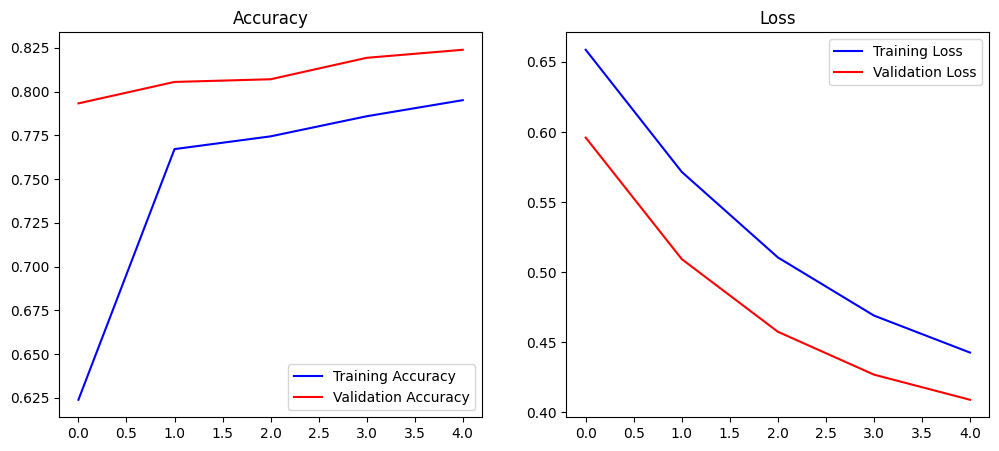

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_training(history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/Parkisons_detection


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Parkisons_detection"
# /content/drive/MyDrive/Colab Notebooks/Parkisons_detection

/content/drive/MyDrive/Colab Notebooks/Parkisons_detection


In [ ]:
model_save_path = "/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/models/xception_attention_model.keras"
model.save(model_save_path, include_optimizer=False)


## Loading the Xception + Attention model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/Parkisons_detection


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Parkisons_detection"
# /content/drive/MyDrive/Colab Notebooks/Parkisons_detection

/content/drive/MyDrive/Colab Notebooks/Parkisons_detection


In [ ]:
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = "/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/models/xception_attention_model.keras"
# /content/drive/MyDrive/Colab Notebooks/Parkisons_detection/models/xception_attention_model.keras

# Load model
xception_w_attention_model = load_model(model_path, custom_objects={'SpatialAttention': SpatialAttention})

print("✅ Xception + Attention Model loaded successfully!")

✅ Xception + Attention Model loaded successfully!


In [ ]:
# Compile
xception_w_attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
import numpy as np

# Predict raw probabilities on val_ds
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = xception_w_attention_model.predict(images, verbose=0)
    y_pred.extend(preds.flatten())
    y_true.extend(labels.numpy())

# Binary threshold
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_binary, target_names=["Healthy", "Parkinson"]))

              precision    recall  f1-score   support

     Healthy       0.78      0.89      0.84       327
   Parkinson       0.88      0.75      0.81       326

    accuracy                           0.82       653
   macro avg       0.83      0.82      0.82       653
weighted avg       0.83      0.82      0.82       653



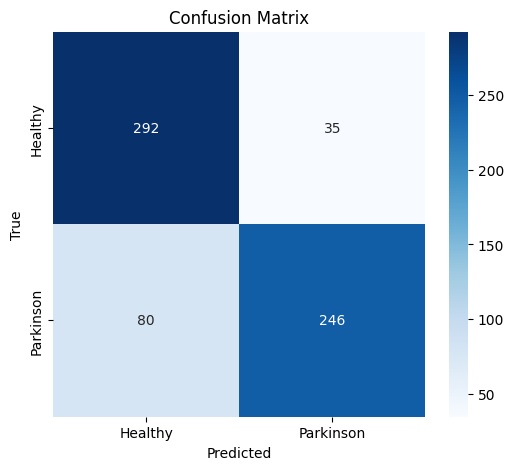

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Healthy", "Parkinson"], yticklabels=["Healthy", "Parkinson"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

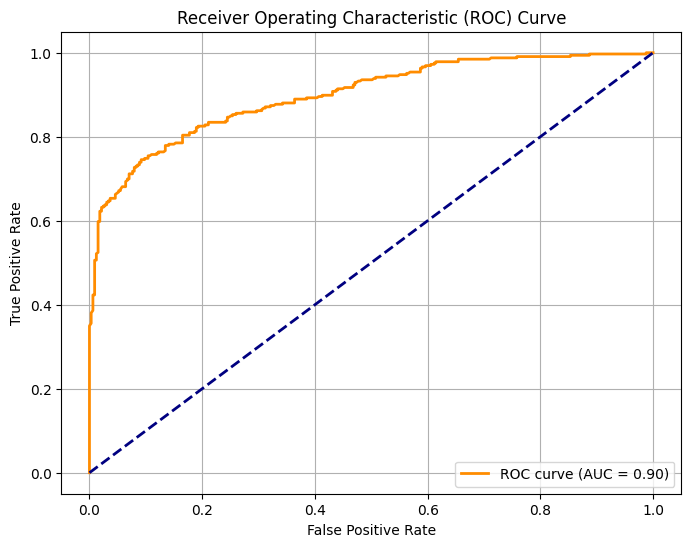

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

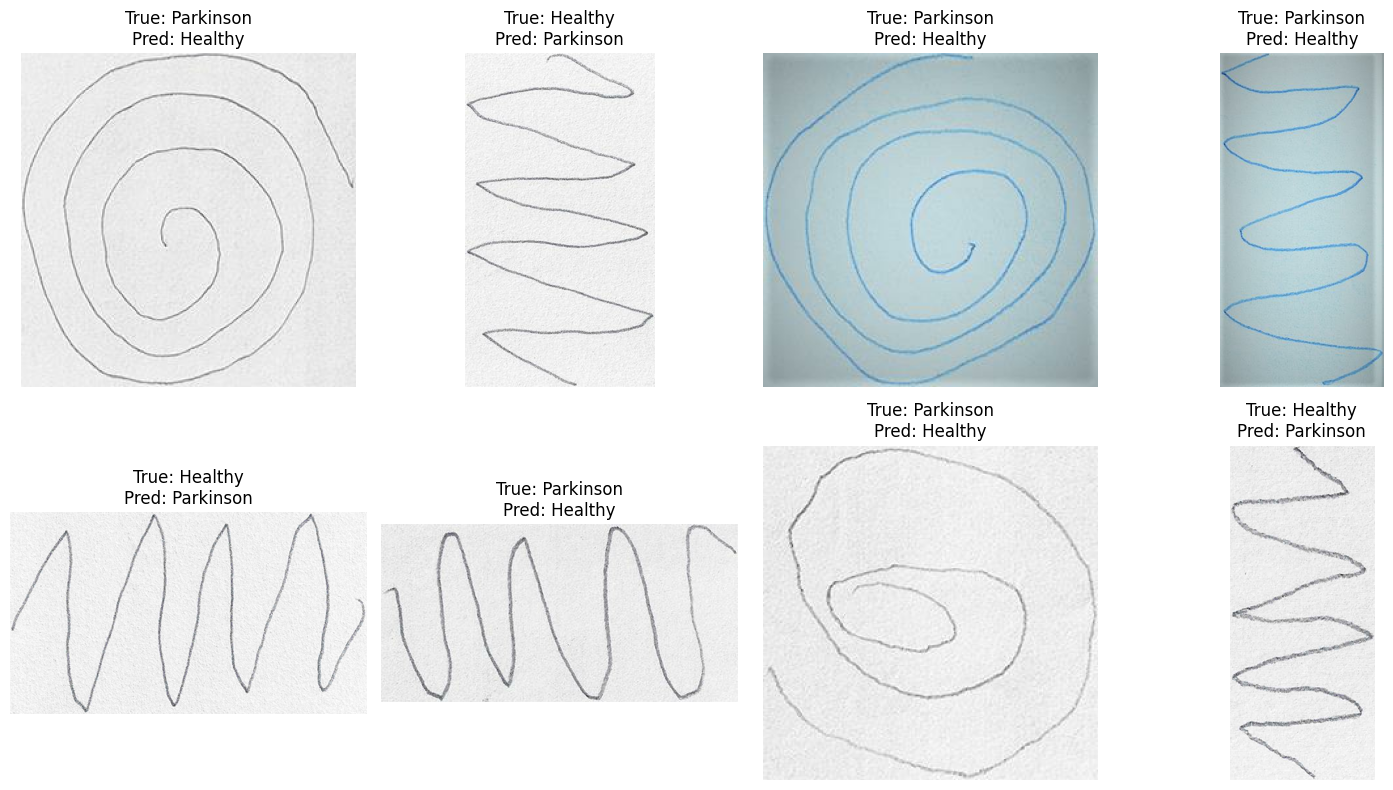

In [ ]:
# Load paths and labels
val_paths = np.load("/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/Preprocessed/val_paths.npy")
val_labels = np.load("/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/Preprocessed/val_labels.npy")

# Display N misclassified samples
import tensorflow as tf

num_to_show = 8
count = 0
plt.figure(figsize=(15, 8))

for i in range(len(y_true)):
    if y_true[i] != y_pred_binary[i]:
        img = tf.io.read_file(val_paths[i])
        img = tf.image.decode_jpeg(img, channels=3)
        plt.subplot(2, 4, count + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"True: {'Parkinson' if y_true[i] else 'Healthy'}\nPred: {'Parkinson' if y_pred_binary[i] else 'Healthy'}")
        count += 1
        if count == num_to_show:
            break

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


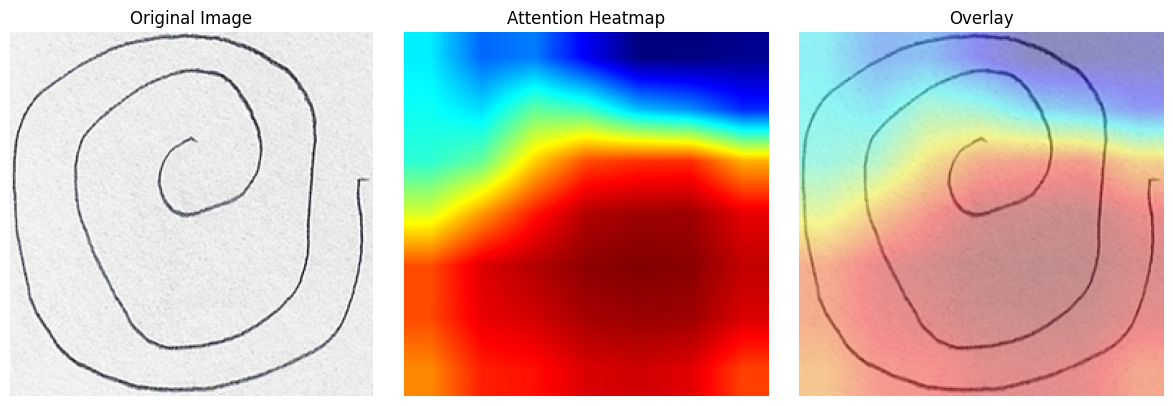

In [ ]:
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load paths
val_paths = np.load("/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/Preprocessed/val_paths.npy")

# Load and preprocess one sample
sample_path = val_paths[10]  # or any index
img_raw = tf.io.read_file(sample_path)
img = tf.image.decode_jpeg(img_raw, channels=3)
img_resized = tf.image.resize(img, [224, 224]) / 255.0
img_batch = tf.expand_dims(img_resized, axis=0)

# Create new attention-extracting model
for layer in xception_w_attention_model.layers:
    if isinstance(layer, SpatialAttention):
        attention_layer = layer
        break

# Set the attention layer to return attention
attention_layer.return_attention = True

# Create sub-model to get attention output
attention_model = Model(inputs=xception_w_attention_model.input, outputs=attention_layer.output)

# Predict attention map
attention_map = attention_model.predict(img_batch)[0, :, :, 0]  # shape (H, W)

# Normalize attention for display
attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))
attention_map = np.uint8(255 * attention_map)

# Resize attention to match image
attention_map_resized = tf.image.resize(tf.expand_dims(attention_map, -1), [224, 224])
attention_map_resized = tf.squeeze(attention_map_resized).numpy().astype("uint8")

# Apply colormap
import cv2
heatmap = cv2.applyColorMap(attention_map_resized, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Overlay heatmap on image
# overlay = cv2.addWeighted(img_resized.numpy(), 0.6, heatmap / 255.0, 0.4, 0)
# Overlay heatmap on image (with correct dtype handling)
overlay = cv2.addWeighted(
    img_resized.numpy().astype(np.float32),
    0.6,
    (heatmap / 255.0).astype(np.float32),
    0.4,
    0
)


# Show
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img.numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Attention Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = xception_w_attention_model.evaluate(val_ds)
print(f"🧪 Validation Accuracy: {accuracy * 100:.2f}%")
print(f"📉 Validation Loss: {loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.8238 - loss: 0.4278
🧪 Validation Accuracy: 82.39%
📉 Validation Loss: 0.4090


In [ ]:
def predict_sample_for_xception(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))  # match your model input
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, 0)  # add batch dimension

    prediction = xception_w_attention_model.predict(img)[0][0]
    label = "Parkinson" if prediction > 0.5 else "Healthy"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"Prediction: {prediction}")
    print(f"🧠 Prediction: {label} ({confidence * 100:.2f}%)")

# Example
# predict_sample(val_paths[150])

In [ ]:
# Example
predict_sample_for_xception(val_paths[150])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: 0.79248046875
🧠 Prediction: Parkinson (79.25%)


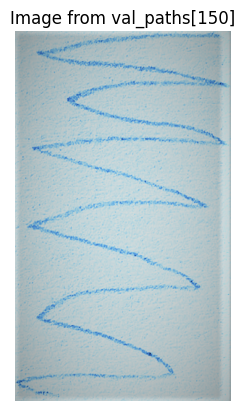

📄 Image path: /content/drive/MyDrive/Colab Notebooks/Parkisons_detection/Dataset/Parkinson/Parkinson1631.png


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Get image path
img_path = val_paths[150]

# Load and display
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)

plt.imshow(img.numpy().astype("uint8"))
plt.axis('off')
plt.title("Image from val_paths[150]")
plt.show()

# Optional: Print path
print(f"📄 Image path: {img_path}")

# Comaprison Inception_w_attention VS Xception_w_attention

In [ ]:
# Evaluate on validation set
inception_results = inception_w_attention_model.evaluate(val_ds, verbose=0)
xception_results = xception_w_attention_model.evaluate(val_ds, verbose=0)

print(f"🔷 Inception + Attention - Loss: {inception_results[0]:.4f}, Accuracy: {inception_results[1]*100:.2f}%")
print(f"🔶 Xception + Attention - Loss: {xception_results[0]:.4f}, Accuracy: {xception_results[1]*100:.2f}%")


🔷 Inception + Attention - Loss: 0.3439, Accuracy: 85.30%
🔶 Xception + Attention - Loss: 0.4090, Accuracy: 82.39%


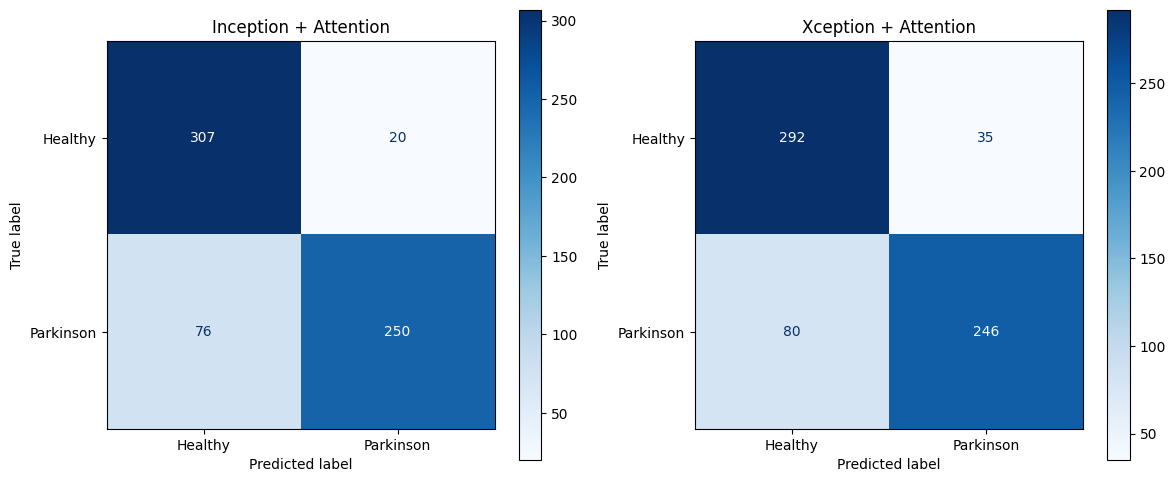

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (model_name, preds) in enumerate([
    ("Inception + Attention", inception_preds),
    ("Xception + Attention", xception_preds)
]):
    cm = confusion_matrix(val_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Parkinson"])
    disp.plot(ax=axes[i], values_format='d', cmap="Blues")
    axes[i].set_title(model_name)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels
val_labels = np.load("/content/drive/MyDrive/Colab Notebooks/Parkisons_detection/Preprocessed/val_labels.npy")

# Get predictions
inception_preds = (inception_w_attention_model.predict(val_ds) > 0.5).astype(int)
xception_preds = (xception_w_attention_model.predict(val_ds) > 0.5).astype(int)

print("🔷 Inception + Attention Report:\n", classification_report(val_labels, inception_preds))
print("🔶 Xception + Attention Report:\n", classification_report(val_labels, xception_preds))


11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 900ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step
🔷 Inception + Attention Report:
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       327
           1       0.93      0.77      0.84       326

    accuracy                           0.85       653
   macro avg       0.86      0.85      0.85       653
weighted avg       0.86      0.85      0.85       653

🔶 Xception + Attention Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.84       327
           1       0.88      0.75      0.81       326

    accuracy                           0.82       653
   macro avg       0.83      0.82      0.82       653
weighted avg       0.83      0.82      0.82       653



11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


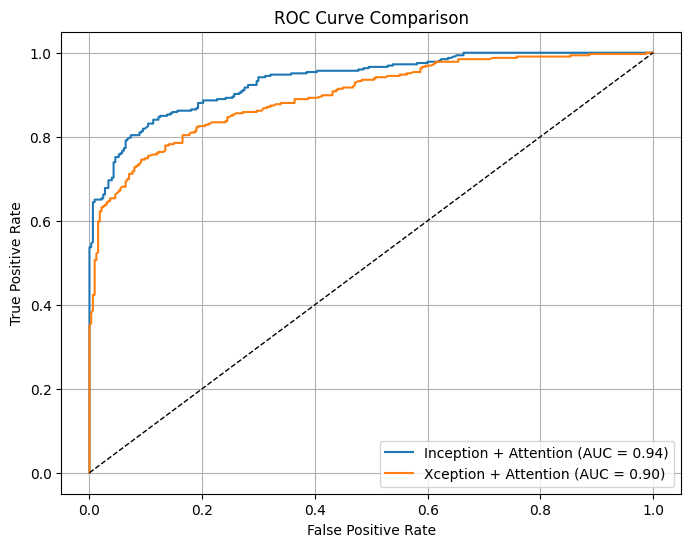

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Raw probabilities
inception_probs = inception_w_attention_model.predict(val_ds).ravel()
xception_probs = xception_w_attention_model.predict(val_ds).ravel()

fpr_in, tpr_in, _ = roc_curve(val_labels, inception_probs)
fpr_xc, tpr_xc, _ = roc_curve(val_labels, xception_probs)

auc_in = auc(fpr_in, tpr_in)
auc_xc = auc(fpr_xc, tpr_xc)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_in, tpr_in, label=f"Inception + Attention (AUC = {auc_in:.2f})")
plt.plot(fpr_xc, tpr_xc, label=f"Xception + Attention (AUC = {auc_xc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


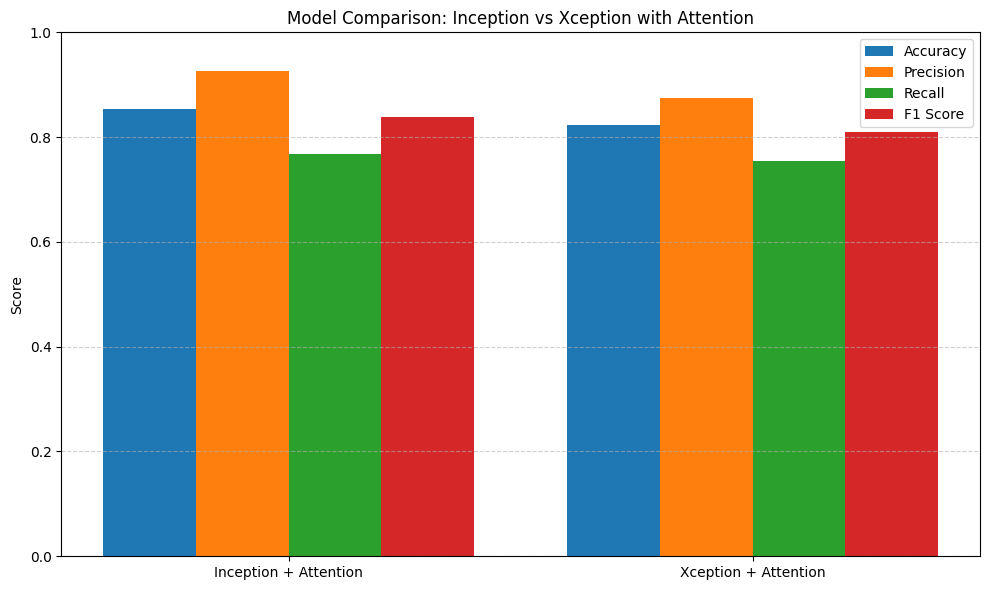

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ For Inception model
y_true_inc = val_labels
y_pred_inc = (inception_w_attention_model.predict(val_ds) > 0.5).astype(int).flatten()

acc_inception = accuracy_score(y_true_inc, y_pred_inc)
prec_inception = precision_score(y_true_inc, y_pred_inc)
rec_inception = recall_score(y_true_inc, y_pred_inc)
f1_inception = f1_score(y_true_inc, y_pred_inc)

# ✅ For Xception model
y_pred_xcp = (xception_w_attention_model.predict(val_ds) > 0.5).astype(int).flatten()

acc_xception = accuracy_score(y_true_inc, y_pred_xcp)
prec_xception = precision_score(y_true_inc, y_pred_xcp)
rec_xception = recall_score(y_true_inc, y_pred_xcp)
f1_xception = f1_score(y_true_inc, y_pred_xcp)


models = ['Inception + Attention', 'Xception + Attention']
accuracy = [acc_inception, acc_xception]
precision = [prec_inception, prec_xception]
recall = [rec_inception, rec_xception]
f1 = [f1_inception, f1_xception]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, accuracy, width, label='Accuracy')
plt.bar(x - 0.5*width, precision, width, label='Precision')
plt.bar(x + 0.5*width, recall, width, label='Recall')
plt.bar(x + 1.5*width, f1, width, label='F1 Score')

plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Comparison: Inception vs Xception with Attention")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
!pip install tabulate

In [ ]:
from tabulate import tabulate

results = [
    ["Model", "Accuracy", "Precision", "Recall", "F1 Score"],
    ["Inception + Attention", f"{acc_inception:.4f}", f"{prec_inception:.4f}", f"{rec_inception:.4f}", f"{f1_inception:.4f}"],
    ["Xception + Attention", f"{acc_xception:.4f}", f"{prec_xception:.4f}", f"{rec_xception:.4f}", f"{f1_xception:.4f}"]
]

print(tabulate(results, headers="firstrow", tablefmt="fancy_grid"))


╒═══════════════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model                 │   Accuracy │   Precision │   Recall │   F1 Score │
╞═══════════════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Inception + Attention │     0.853  │      0.9259 │   0.7669 │     0.8389 │
├───────────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Xception + Attention  │     0.8239 │      0.8754 │   0.7546 │     0.8105 │
╘═══════════════════════╧════════════╧═════════════╧══════════╧════════════╛
